# Анализ данных в задаче кредитного скоринга

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

from scipy import stats

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('data/credit_card_default_analysis.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский)
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [6]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

**Подготовим данные**

In [7]:
LIMIT_BAL_0 = data['LIMIT_BAL'][data['default'] == 0].values
LIMIT_BAL_1 = data['LIMIT_BAL'][data['default'] == 1].values

#### Посмотрим на распределения кредитных лимитов отдельно для возвратных и невозвратных кредитов.

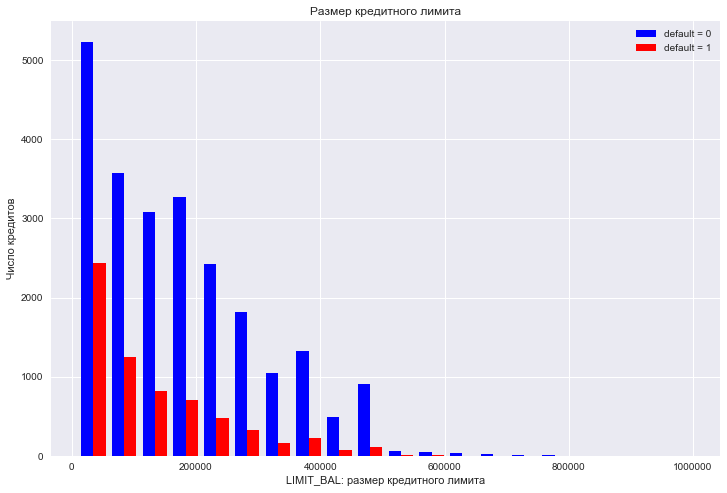

In [9]:
pylab.figure(figsize=(12,8))

pylab.grid(b=True)
pylab.hist([LIMIT_BAL_0, LIMIT_BAL_1], bins=20, color = ['b', 'r'])
pylab.xlabel(u'LIMIT_BAL: размер кредитного лимита')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Размер кредитного лимита')
pylab.legend(['default = 0', 'default = 1'])

pylab.show()

Поскольку **сравниваем медианы**, посмотрим на это еще и так:

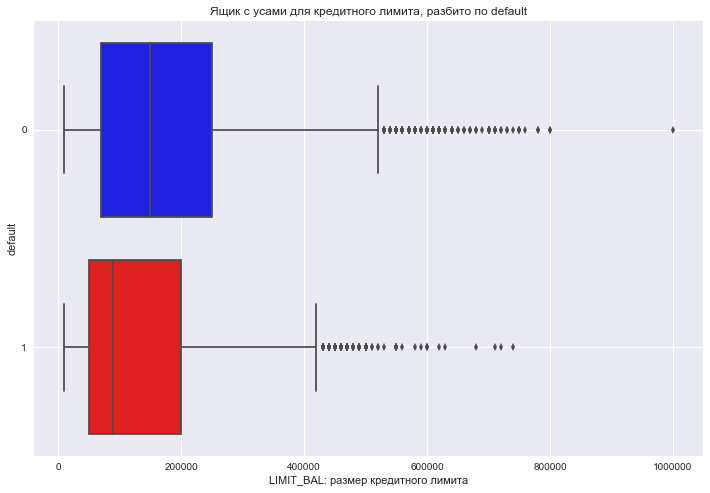

In [11]:
pylab.figure(figsize=(12,8))

sns.boxplot(data=[LIMIT_BAL_0, LIMIT_BAL_1], palette = {0:'b', 1:'r'}, vert=False)
pylab.grid(b=True)
pylab.ylabel(u'default')
pylab.xlabel(u'LIMIT_BAL: размер кредитного лимита')
pylab.title(u'Ящик с усами для кредитного лимита, разбито по default')

pylab.show()

#### Вычислим отдельно медианы кредитных лимитов для возвратных и невозвратных кредитов.

In [12]:
data.groupby('default')[['LIMIT_BAL']].median()

,LIMIT_BAL
default,
0,150000
1,90000


#### Визуальный анализ распределений:   
Левый график - распределение кредитного лимита для возвратных кредитов. Видим, что таких кредитов, как и ожидалось, существенно больше, суммы здесь в среднем больше. С ростом кредитного лимита число выданных возвратных кредитов падает не так быстро, в то время как для невозвратных кредитов это падение гораздо существеннее в сравнении с возвратными кредитами. Для невозвратных кредитов преобладают небольшие кредитные лимиты.

**Видим, что визуальная и точечная оценка медиан кредитных лимитов и внешний вид распределений отличаются. Посмотрим, что скажут критерии.**

### a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

Для ответа на этот вопрос определим **интервальную оценку разности медиан**. Воспользуемся методологией **bootstrap**.

In [13]:
def get_bootstrap_samples(data, n_samples):
    '''
    Возвращает бутстрап выборки из данных
    '''
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [14]:
def stat_intervals(stat, alpha):
    '''
    Возвращает границы (100-alpha)-процентного интервала для статистики stat
    '''
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Интервальная оценка медианы

In [15]:
np.random.seed(17)

LIMIT_BAL_0_median_scores = map(np.median, get_bootstrap_samples(LIMIT_BAL_0, 1000))
LIMIT_BAL_1_median_scores = map(np.median, get_bootstrap_samples(LIMIT_BAL_1, 1000))

print "95% confidence interval for the default=0 median LIMIT_BAL:",  stat_intervals(LIMIT_BAL_0_median_scores, 0.05)
print "95% confidence interval for the default=1 median LIMIT_BAL:",  stat_intervals(LIMIT_BAL_1_median_scores, 0.05)

95% confidence interval for the default=0 median LIMIT_BAL: [ 150000.  150000.]
95% confidence interval for the default=1 median LIMIT_BAL: [ 80000.  90000.]


#### Точечная оценка разности медиан

In [16]:
print "difference between medians:", np.median(LIMIT_BAL_1) - np.median(LIMIT_BAL_0)

difference between medians: -60000.0


#### Интервальная оценка разности медиан

In [17]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(LIMIT_BAL_0_median_scores, LIMIT_BAL_1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-70000. -60000.]


**ВЫВОД: **

Поскольку интервальная оценка разности не содержит ноль, то  медианные значения кредитного лимита возвратных и невозвратных кредитов не совпадают.

### b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Выбирая критерий, будем учитывать следующее:
- две выборки
- выборки независимы

Будем применять **двухвыборочные критерии для независимых выборок**.   
Для этого подгходят:
- ранговый критерий Манна-Уитни
- перестановочный критерий

### Ранговый критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ (распределения и средние равны)

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ (распределения и средние не равны, двусторонняя альтернатива)

In [18]:
stats.mannwhitneyu(LIMIT_BAL_0, LIMIT_BAL_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

Достигаемый уровень значимости гипотезы о равенстве распределений **pvalue = 6.1277429091116516e-190**

**ВЫВОД**:   
pvalue значительно < 0.05, поэтому нулевую гипотезу о равенстве средних отвергаем на уровне значимости 0.05

### Перестановочный критерий   

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ (распределения и средние равны)

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ (распределения и средние не равны, двусторонняя альтернатива)

In [19]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [20]:
print "p-value: %f" % permutation_test(LIMIT_BAL_0, LIMIT_BAL_1, max_permutations = 10000)

p-value: 0.000100


Достигаемый уровень значимости гипотезы о равенстве распределений **pvalue = 0.000100**.

В обоих тестах достигаемый уровень значимости **pvalue** значительно **< 0.05**, поэтому на уровне значимости 0.05 гипотеза о равенстве распределений (и, следовательно, средних) с уверенностью отвергается.

Полученные результаты **эначимы с практической точки зрения**, поскольку по величине потенциального кредита позволяют судить о его возвратности. В частности, кредиты размером около **150 тысяч более возвратны**, чем кредиты размером 80 - 90 тысяч.

## Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей, вернувших и не вернувших кредит, отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [21]:
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

У нас получается задача о равенстве долей **двух независимых выборок**.

Будем мониторить **долю мужчин** (для определенности) в обеих выборках.

#### Подготовим данные:

In [22]:
SEX_male_0 = (data['SEX'] == 1).astype(int)[data['default'] == 0].values
SEX_male_1 = (data['SEX'] == 1).astype(int)[data['default'] == 1].values

Визуализируем:

In [23]:
table_2 = pd.crosstab(data['default'], data['SEX'])
table_2

SEX,1,2
default,,
0,9015,14349
1,2873,3763


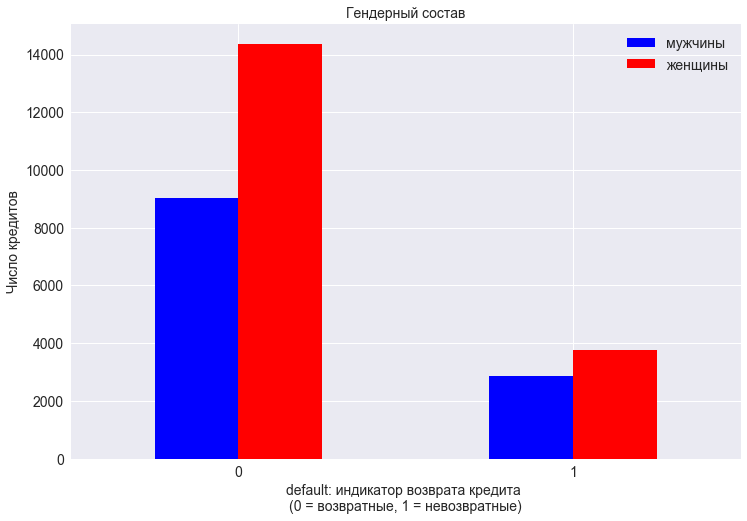

In [24]:
table_2.plot.bar(color='br', rot=0, figsize=(12,8), fontsize=14)
pylab.xlabel(u'default: индикатор возврата кредита \n(0 = возвратные, 1 = невозвратные)', fontsize=14)
pylab.ylabel(u'Число кредитов', fontsize=14)
pylab.title(u'Гендерный состав', fontsize=14)
pylab.legend([u'мужчины', u'женщины'], fontsize=14)

pylab.show()

**Анализ распределений:**   
Видим, что доля женщин в обеих группах преобладает, однако на глаз доля мужчин в группе невозвратных кредитов больше, чем в группе возвратных кредитов, то есть **гендерные составы разные**. Проверим это.

Посмотрим на **точечные** оценки доли:

In [27]:
print 'доля мужчин в группе с default = 0:', SEX_male_0.mean()
print 'доля мужчин в группе с default = 1:', SEX_male_1.mean()

доля мужчин в группе с default = 0: 0.385850025681
доля мужчин в группе с default = 1: 0.432941531043


#### а) **Проверка 1.** Определение доверительных интервалов долей в обеих группах.

Доверительный интервал для доли можно строить на основе нормального распределения с использованием центральной предельной теоремы. Формула для такого интервала:

$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [28]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [30]:
normal_interval_male_0 = proportion_confint(sum(SEX_male_0), len(SEX_male_0), alpha=0.05, method = 'normal')
normal_interval_male_1 = proportion_confint(sum(SEX_male_1), len(SEX_male_1), alpha=0.05, method = 'normal')

In [31]:
print 'границы нормального интервала доли мужчин в группе с возвратными кредитами: [%.4f, %.4f]' % normal_interval_male_0
print 'границы нормального интервала доли мужчин в группе с не возвратными кредитами: [%.4f, %.4f]' % normal_interval_male_1

границы нормального интервала доли мужчин в группе с возвратными кредитами: [0.3796, 0.3921]
границы нормального интервала доли мужчин в группе с не возвратными кредитами: [0.4210, 0.4449]


**ВЫВОД:** 95%-е доверительные интервалы долей мужчин в обеих группах не пересекаются ==> гендерный состав групп **различается**.

#### б) Проверка 2. Доверительный интервал для разности долей (независимые выборки)

In [32]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [33]:
print "Доверительный интервал для разности долей: [%f, %f]" % proportions_confint_diff_ind(SEX_male_0, SEX_male_1)

Доверительный интервал для разности долей: [-0.060548, -0.033635]


**ВЫВОД:** 95%-й доверительный интервал для разности долей мужчин в обеих группах не содержит ноль ==> гендерный состав групп **различается**

#### в) Проверка 3. Z-критерий для разности долей (независимые выборки).

**Критерий применимости:**   
- Критерия работает для распределения Бернулли и применяется для бинарных событий, выборка состоит из 0 и 1 - **выполняется (для подготовленных выше данных)**
- независимые выборки - **выполняется**

Нулевая гипотеза $H_0$: $p_1$ = $p_2$ - гендерные составы групп равны    
Альтернатива $H_1$: $p_1 \ne p_2$, двусторонняя

Выборки несвязанные (независимые)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [34]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [35]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [37]:
print "p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(SEX_male_0, SEX_male_1))

 p-value: 4.47286652161e-12


**ВЫВОД:** Достигаемый уровень значимости при истинности гипотезы о равенстве гендерных составов обеих групп **pvalue = 4е-12**, он **отвергается** на уровне значимости 0.05 в пользу двусторонней альтернативы, что **составы различаются**.   
Результаты практически значимы, они позволяют сделать вывод о том, что мужчины чаще не возвращают кредит, чем женщины.

## Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?

Для начала посмотрим на графики с анализируемыми данными

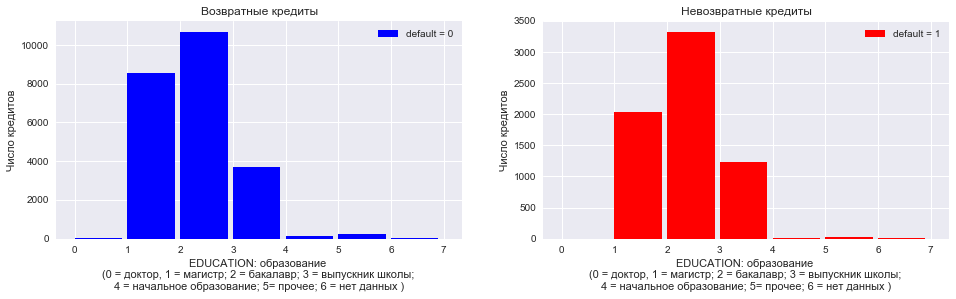

In [38]:
pylab.figure(figsize=(16,4))

pylab.subplot(1,2,1)
pylab.grid(b=True)
pylab.hist(data['EDUCATION'][data['default'] == 0], color = 'b', bins=7, width=0.9, range=(0, 7), label = 'default = 0')
pylab.xlabel(u'EDUCATION: образование \n(0 = доктор, 1 = магистр; 2 = бакалавр; \
3 = выпускник школы; \n4 = начальное образование; 5= прочее; 6 = нет данных )')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Возвратные кредиты')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid(b=True)
pylab.hist(data['EDUCATION'][data['default'] == 1], color = 'r', bins=7, width=0.9, range=(0, 7), label = 'default = 1')
pylab.xlabel(u'EDUCATION: образование \n(0 = доктор, 1 = магистр; 2 = бакалавр; \
3 = выпускник школы; \n4 = начальное образование; 5= прочее; 6 = нет данных )')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Невозвратные кредиты')
pylab.legend()

pylab.show()

**Анализ распределений:**   
Масштабы распределений отличаются примерно в 3 раза, как и ожидалось, то есть невозвратных кредитов в целом примерно в 3 раза меньше. Внешний вид распределений в целом похожи, доля магистров в возвратных кредитах на вид больше. Посмотрим по критериям, может ли степень образования быть индикатором невозвратности кредита.

Здесь имеем дело с **корреляцией категориальных величиг**.

Используем критерий $\chi$-квадрат. Этот критерий для таблиц сопряженности может применяться при выполнении следующих условий.
- Нужно, чтобы выборки были достаточно большими: $n \ge 40$. 
- Кроме того, необходимо, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5 не более, чем в 20% ячеек.

Проверим:

Сформируем **наблюдаемую таблицу сопряженности**.

In [39]:
table = pd.crosstab(data['EDUCATION'], data['default'])
table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [40]:
print u'Размер выборки:', np.sum(np.array(table))
print u'Доля ячеек с ожидаемым количством элементов меньше 5:', 1.* np.sum(np.array(table) < 5) / \
                                                                (table.shape[0] * table.shape[1])

Размер выборки: 30000
Доля ячеек с ожидаемым количством элементов меньше 5: 0.0714285714286


**Вывод:**   
Условия применимости критерия $\chi$-квадрат - **выполняются**

**Формулируем гипотезы.**

Имеется выборка $(X_{1i}, X_{2i})$,   
где   
    $X_{1i}\in \{0, 1, ..., 6\}$ - образование,   
    $X_{1i}\in \{0, 1\}$ - индикатор возврата кредита.   
    
Нулевая гипотеза $H_0$: $X_{1}$ и $X_{2}$ - независимы, то есть образование не влияет на то, вернет ли человек долг.   
Альтернатива $H_1$: $H_0$ - неверна.   
Статистика: $\chi^2(X_{1}^n, X_{2}^n)$   

Или, по другому, проверяем гипотезу о равенстве нулю коэффициента **V Крамера** против альтернативы, что он нулю не равен.

Посчитаем **статистику $\chi^2$**, **уровень достигаемой значимости  $pv$** и **таблицу ожидаемых значений** в таблице сопряженности $expected$

In [41]:
chi2, pv, dof, expected = scipy.stats.chi2_contingency(table)

In [42]:
print 'chi2 =', chi2
print 'pv =', pv

chi2 = 163.21655787
pv = 1.23326262454e-32


**ВЫВОД:**   
Поскольку достигаемый уровень значимости $pv = 1e-32 << 0.05$, то на уровне значимости 0.05 нулевая гипотеза о том, что образование не влияет на то, вернет ли человек долг - **отвергается**. Другими словами - образование **влияет** на то, вернет ли человек долг.

Посмотрим на **таблицу сопряженности ожидаемых** значений количества человек. Для наглядности переведем ее в датафрейм и округлим до целых (плюс сделаем значения целочисленными).

In [43]:
expected_table = pd.DataFrame(expected).applymap(round).astype(int) 
expected_table

,0,1
0,11,3
1,8244,2341
2,10927,3103
3,3829,1088
4,96,27
5,218,62
6,40,11


Сформируем **таблицу сопряженности** "образование" на "возврат долга", где значением ячейки будет **разность** между наблюдаемым и ожидаемым количеством человек. 

In [44]:
table - expected_table

default,0,1
EDUCATION,,
0,3,-3
1,305,-305
2,-227,227
3,-149,149
4,20,-20
5,44,-44
6,3,-3


Способ для улучшения интерпретируемости:    
представим **таблицу сопряженности** в таком виде, где **отклонение** в каждой ячейке выразим **в процентах от ожидаемого** (плюс округлим):

In [45]:
((table - expected_table) / expected_table * 100).applymap(round).astype(int)

default,0,1
EDUCATION,,
0,27,-100
1,4,-13
2,-2,7
3,-4,14
4,21,-74
5,20,-71
6,8,-27


Ответим на вопросы:   

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? **Ответ:** $0$ - доктор   
Наоборт, не отдаст долг? **Ответ:** $3$ - выпускник школы   

## Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Посмотрим на графики с анализируемыми данными

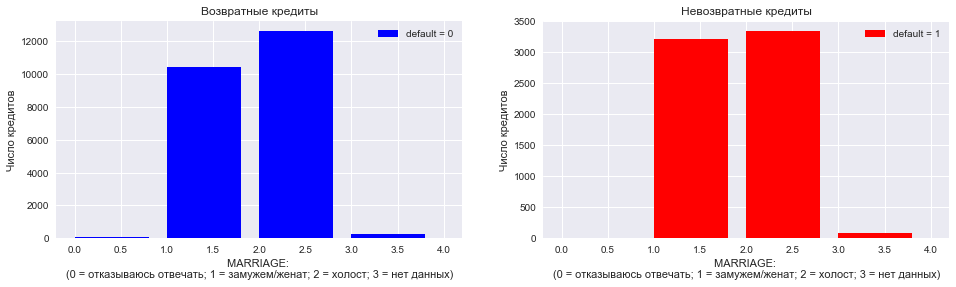

In [46]:
pylab.figure(figsize=(16,4))

pylab.subplot(1,2,1)
pylab.grid(b=True)
pylab.hist(data['MARRIAGE'][data['default'] == 0], color = 'b', bins=4, width=0.8, range=(0, 4), label = 'default = 0')
pylab.xlabel(u'MARRIAGE: \n(0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Возвратные кредиты')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid(b=True)
pylab.hist(data['MARRIAGE'][data['default'] == 1], color = 'r', bins=4, width=0.8, range=(0, 4), label = 'default = 1')
pylab.xlabel(u'MARRIAGE: \n(0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Невозвратные кредиты')
pylab.legend()

pylab.show()

Посмотрим на эти данные с другого ракурса.

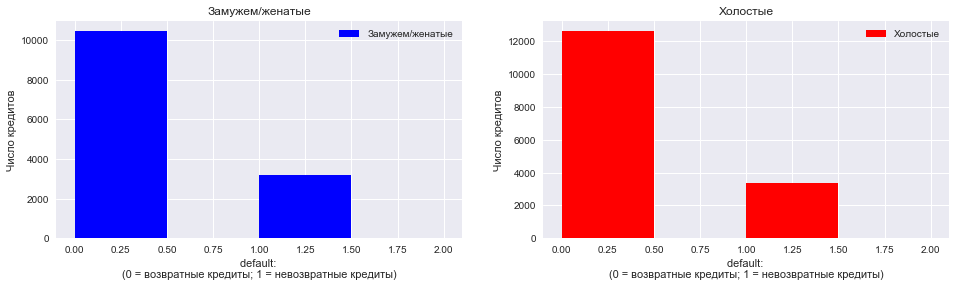

In [47]:
pylab.figure(figsize=(16,4))

pylab.subplot(1,2,1)
pylab.grid(b=True)
pylab.hist(data['default'][data['MARRIAGE'] == 1], color = 'b', bins=2, width=0.5, range=(0, 2), label = u'Замужем/женатые')
pylab.xlabel(u'default: \n(0 = возвратные кредиты; 1 = невозвратные кредиты)')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Замужем/женатые')
pylab.legend()

pylab.subplot(1,2,2)
pylab.grid(b=True)
pylab.hist(data['default'][data['MARRIAGE'] == 2], color = 'r', bins=2, width=0.5, range=(0, 2), label = u'Холостые')
pylab.xlabel(u'default: \n(0 = возвратные кредиты; 1 = невозвратные кредиты)')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Холостые')
pylab.legend()

pylab.show()

**Анализ распределений:**   
Видим, что в целом замужние/женатые берут кредит немного реже холостых, при этом доля холостых в невозвратных кредитах немного больше, чем аналогичная доля в возвратных кредитах. 

В качестве меры связи семейного статуса с индикатором дефолта возьмем значение коэффициента корреляции Крамера **V Cramer**

Посчитаем определенныю выше меру:

Подготовим данные:

In [48]:
table_MARR = pd.crosstab(data['MARRIAGE'], data['default'])
table_MARR

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Вычислим V_Cramer через статистику $\chi$ квадрат.

In [49]:
chi2, pv, dof, expected = stats.chi2_contingency(table_MARR)

In [50]:
n = table_MARR.sum().sum()
V_Cramer = np.sqrt(chi2 / n * min(table_MARR.shape[0], table_MARR.shape[1] - 1))

In [51]:
print 'V_Cramer =', V_Cramer
print 'pv =', pv

V_Cramer = 0.0344782036628
pv = 8.82586245758e-08


**ВЫВОД:**   
Значение коэффициента корреляции Крамера, равное $0.0345$, показывает, что семейное положение заемщика мало влияет на возвратность кредита.   
Тем более, что поскольку $pv = 9e-8$, то на уровне значимости 0.05 гипотеза о зависимости семейного положения и возвратности кредита отвергается.

## Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

Подготовим данные

In [52]:
AGE_0 = data['AGE'][data['default'] == 0].values      # возрасты людей, возвращающих кредиты
AGE_1 = data['AGE'][data['default'] == 1].values      # возрасты людей, НЕвозвращающих кредиты

Посмотрим на графики

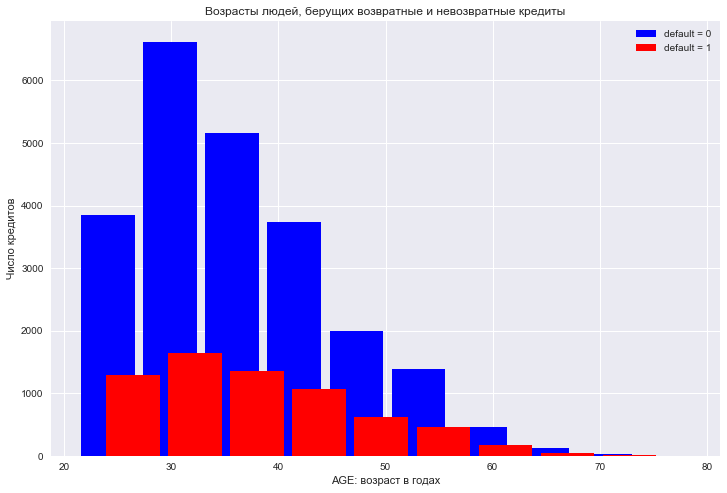

In [53]:
pylab.figure(figsize=(12,8))

pylab.grid(b=True)
pylab.hist([AGE_0, AGE_1], color = ['b', 'r'], width=5, label = ['default = 0', 'default = 1'])
pylab.xlabel(u'AGE: возраст в годах')
pylab.ylabel(u'Число кредитов')
pylab.title(u'Возрасты людей, берущих возвратные и невозвратные кредиты')
pylab.legend()

pylab.show()

Посмотрим на это по-другому:

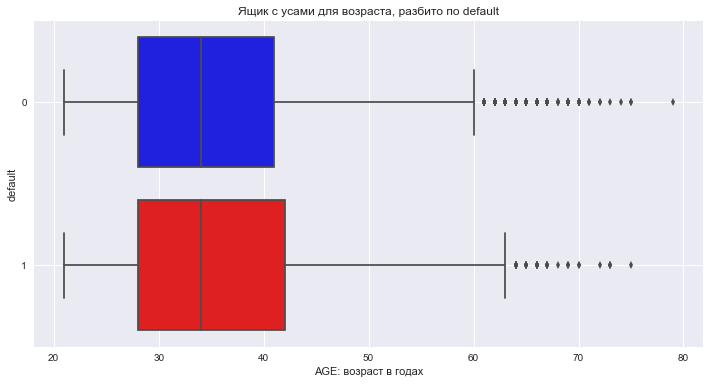

In [54]:
pylab.figure(figsize=(12,6))
# pylab.boxplot([AGE_0, AGE_1], vert=False, labels=[0, 1])
sns.boxplot(data=[AGE_0, AGE_1], palette = {0:'b', 1:'r'}, vert=False)
pylab.grid(b=True)
pylab.ylabel(u'default')
pylab.xlabel(u'AGE: возраст в годах')
pylab.title(u'Ящик с усами для возраста, разбито по default')
# pylab.legend(['default=0','default=1'])

pylab.show()

Посмотрим отдельно на медианы возрастов для возвратных и невозвратных кредитов.

In [55]:
data.groupby('default')[['AGE']].median()

,AGE
default,
0,34
1,34


**Визуальный анализ распределений:**   
Видим, что для невозвратных кредитов более тяжелый правый хвост, то есть невозвратность более характерна для людей более старшего возраста.

**Медианы для этих групп людей, возвращающих и не возвращающих кредиты, совпадают и равны 34 годам.**   
Проверим соответствующие гипотезы.

### a) о равенстве медианных значений возрастов людей

Для ответа на этот вопрос воспользуемся **интервальной оценкой разности медиан** с применением методологии **bootstrap**.

In [56]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [57]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

**Точечная оценка разности медиан**

In [58]:
print "difference between medians:", np.median(AGE_1) - np.median(AGE_0)

difference between medians: 0.0


**Интервальная оценка разности медиан**

In [59]:
np.random.seed(17)

AGE_0_median_scores = map(np.median, get_bootstrap_samples(AGE_0, 1000))
AGE_1_median_scores = map(np.median, get_bootstrap_samples(AGE_1, 1000))

delta_median_scores = map(lambda x: x[1] - x[0], zip(AGE_0_median_scores, AGE_1_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 0.  1.]


**ВЫВОД:**   
95%-й доверительный интервал разности медиан содержит ноль ==> делаем вывод о **равенстве** медиан.

### b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Для ответа на этот вопрос подходят непараметрические критерии - ранговый критерий Манна-Уитни и перестановочный критерий.

### Ранговый критерий Манна-Уитни
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - распределения и средние равны

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - двусторонняя альтернатива о неравенстве равпределений и средних

In [60]:
stats.mannwhitneyu(AGE_0, AGE_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

**ВЫВОД:**   
Достигаемый уровень значимости рангового критерия Манна-Уитни **pv = 0.1863**, отвергнуть гипотезу о равенстве распределений на уровне 0.05 **не можем**.

С практической точки зрения результаты значимы. Они позволяют сделать вывод о том, что возраст не влияет на возвратность кредита